In [19]:
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file
csv_file_path = '/Users/kametayturar/nteprsm/data/raw/quality_nj2.csv'
csv_data = pd.read_csv(csv_file_path)

# Create entry mapping
entry_mapping = csv_data[['ENTRY_CODE', 'ENTRY_NAME']].drop_duplicates().reset_index(drop=True)

print("Entry Mapping (first few rows):")
print(entry_mapping.head())

Entry Mapping (first few rows):
   ENTRY_CODE      ENTRY_NAME
0          37      NAI-14-132
1          25    BAR PP 7236V
2          59  DLFPS-340/3455
3          75           A15-6
4          31       NAI-15-80


In [20]:
# Load the NetCDF file
netcdf_file_path = '/Users/kametayturar/nteprsm/data/model_output/trace_20240710_124044.netcdf'
trace = az.from_netcdf(netcdf_file_path)

# Extract the entry samples
entry_samples = trace.posterior['entry'].values

# Calculate statistics
entry_means = np.mean(entry_samples, axis=(0, 1))
entry_stds = np.std(entry_samples, axis=(0, 1))
entry_2_5_percentile = np.percentile(entry_samples, 2.5, axis=(0, 1))
entry_97_5_percentile = np.percentile(entry_samples, 97.5, axis=(0, 1))

print("Shape of entry_samples:", entry_samples.shape)
print("Number of entries:", len(entry_means))

Shape of entry_samples: (4, 1500, 89)
Number of entries: 89


In [21]:
# Create a DataFrame with these statistics
new_model_data = pd.DataFrame({
    'ENTRY_CODE': entry_mapping['ENTRY_CODE'].values[:len(entry_means)],
    'EFF_RSM': entry_means,
    'STD_RSM': entry_stds,
    '2.5RSM': entry_2_5_percentile,
    '97.5RSM': entry_97_5_percentile
})

# Merge with entry names
new_model_data = new_model_data.merge(entry_mapping, on='ENTRY_CODE', how='left')

print("New Model Data (first few rows):")
print(new_model_data.head())

# Save the new model data
new_model_data_path = "/Users/kametayturar/nteprsm/notebooks/new_model_data.csv"
new_model_data.to_csv(new_model_data_path, index=False)
print(f"New model data saved to {new_model_data_path}")

New Model Data (first few rows):
   ENTRY_CODE   EFF_RSM   STD_RSM    2.5RSM   97.5RSM      ENTRY_NAME
0          37 -0.073316  0.148648 -0.372117  0.212477      NAI-14-132
1          25  0.413668  0.150077  0.121437  0.708806    BAR PP 7236V
2          59  1.147428  0.157986  0.836270  1.459742  DLFPS-340/3455
3          75 -0.863160  0.152690 -1.166243 -0.564901           A15-6
4          31  0.071099  0.148367 -0.217388  0.361911       NAI-15-80
New model data saved to /Users/kametayturar/nteprsm/notebooks/new_model_data.csv


In [22]:
# Load the previous model results
prev_model_file_path = "/Users/kametayturar/nteprsm/data/raw/data.csv"
prev_model_data = pd.read_csv(prev_model_file_path, delimiter=';')

print("Previous Model Data columns:")
print(prev_model_data.columns)

# Merge new and previous model data
merged_data = pd.merge(new_model_data, prev_model_data, on='ENTRY_NAME', suffixes=('_New', '_Prev'))

print("Merged Data (first few rows):")
print(merged_data.head())

# Save the merged data
merged_data_path = "/Users/kametayturar/nteprsm/notebooks/merged_data.csv"
merged_data.to_csv(merged_data_path, index=False)
print(f"Merged data saved to {merged_data_path}")

Previous Model Data columns:
Index(['ENTRY_NAME', 'EFF_LMM', 'STD_LMM', 'Z_LMM', 'P_LMM', '2.5LMM',
       '97.5LMM', 'TEST_LOC', 'EFF_RSM', '2.5RSM', '97.5RSM', 'STD_RSM'],
      dtype='object')
Merged Data (first few rows):
   ENTRY_CODE  EFF_RSM_New  STD_RSM_New  2.5RSM_New  97.5RSM_New  \
0          37    -0.073316     0.148648   -0.372117     0.212477   
1          25     0.413668     0.150077    0.121437     0.708806   
2          59     1.147428     0.157986    0.836270     1.459742   
3          75    -0.863160     0.152690   -1.166243    -0.564901   
4          31     0.071099     0.148367   -0.217388     0.361911   

       ENTRY_NAME  EFF_LMM  STD_LMM  Z_LMM  P_LMM  2.5LMM  97.5LMM  \
0      NAI-14-132   -0.667    0.174 -3.840  0.000  -1.007   -0.326   
1    BAR PP 7236V    0.991    0.174  5.707  0.000   0.650    1.331   
2  DLFPS-340/3455   -0.611    0.174 -3.520  0.000  -0.951   -0.271   
3           A15-6    0.231    0.174  1.333  0.182  -0.109    0.572   
4       NAI-15-

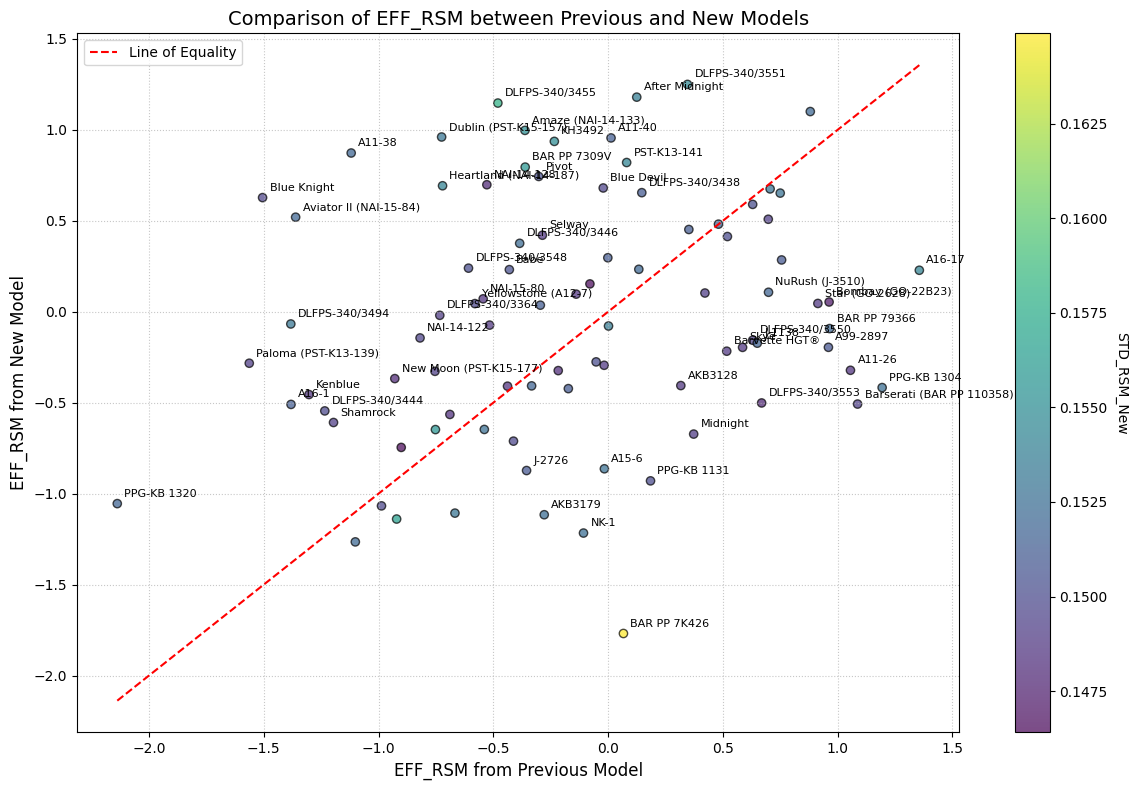

In [15]:
plt.figure(figsize=(12, 8))

scatter = plt.scatter(merged_data['EFF_RSM_Prev'], merged_data['EFF_RSM_New'], 
                      alpha=0.7, edgecolors='k', c=merged_data['STD_RSM_New'], cmap='viridis')

plt.xlabel('EFF_RSM from Previous Model', fontsize=12)
plt.ylabel('EFF_RSM from New Model', fontsize=12)
plt.title('Comparison of EFF_RSM between Previous and New Models', fontsize=14)

min_value = min(merged_data['EFF_RSM_Prev'].min(), merged_data['EFF_RSM_New'].min())
max_value = max(merged_data['EFF_RSM_Prev'].max(), merged_data['EFF_RSM_New'].max())
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Line of Equality')

cbar = plt.colorbar(scatter)
cbar.set_label('STD_RSM_New', rotation=270, labelpad=15)

for i, row in merged_data.iterrows():
    if abs(row['EFF_RSM_New'] - row['EFF_RSM_Prev']) > 0.5:
        plt.annotate(row['ENTRY_NAME'], (row['EFF_RSM_Prev'], row['EFF_RSM_New']),
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
correlation = merged_data['EFF_RSM_New'].corr(merged_data['EFF_RSM_Prev'])
print(f"Correlation coefficient between EFF_RSM_New and EFF_RSM_Prev: {correlation:.4f}")

mean_abs_diff = np.mean(np.abs(merged_data['EFF_RSM_New'] - merged_data['EFF_RSM_Prev']))
print(f"Mean absolute difference between EFF_RSM_New and EFF_RSM_Prev: {mean_abs_diff:.4f}")

Correlation coefficient between EFF_RSM_New and EFF_RSM_Prev: 0.2052
Mean absolute difference between EFF_RSM_New and EFF_RSM_Prev: 0.7202


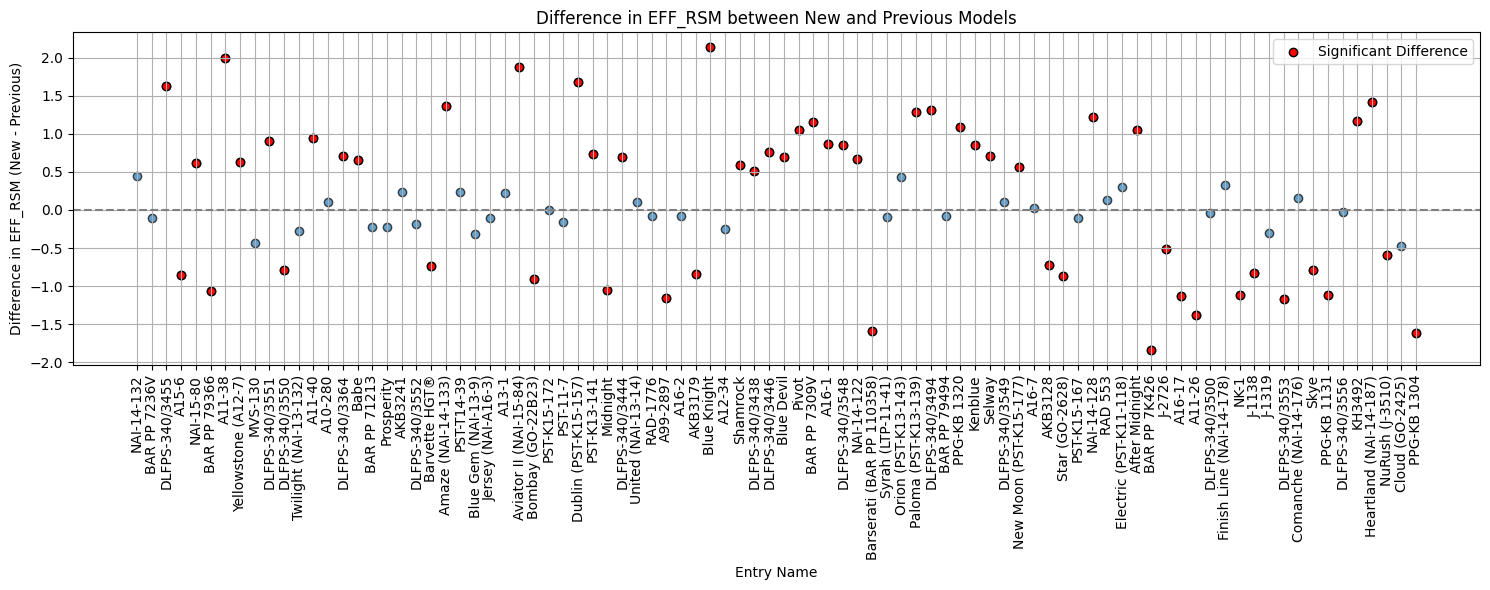

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the difference between the new and previous EFF_RSM values
merged_data['EFF_RSM_Diff'] = merged_data['EFF_RSM_New'] - merged_data['EFF_RSM_Prev']

# Scatter plot to visualize differences
plt.figure(figsize=(15, 6))
plt.scatter(merged_data['ENTRY_NAME'], merged_data['EFF_RSM_Diff'], alpha=0.7, edgecolors='k')

# Highlight points with significant differences
threshold = 0.5  # Define a threshold for significant difference
significant_diff = merged_data[np.abs(merged_data['EFF_RSM_Diff']) > threshold]
plt.scatter(significant_diff['ENTRY_NAME'], significant_diff['EFF_RSM_Diff'], color='red', edgecolors='k', label='Significant Difference')

plt.axhline(0, color='grey', linestyle='--')  # Line at zero difference
plt.xlabel('Entry Name')
plt.ylabel('Difference in EFF_RSM (New - Previous)')
plt.title('Difference in EFF_RSM between New and Previous Models')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
